In [3]:
from sklearn import metrics
import numpy as np
import pandas as pd
import pickle
import re
import mymodule

In [4]:
with open('model/lda_model.pkl', 'rb') as f:
  lda_model = pickle.load(f) #import lda model
  
data = pd.read_csv('dataset/DatasetLegal.csv') #read data
question_data = data['question']
train_question_data = question_data
answer_data = data['answer']
train_answer_data = answer_data

with open('model/topic_dict.pkl', 'rb') as f:
  topic_dict = pickle.load(f)

with open('model/question_lda.pkl', 'rb') as f:
   question_lda = pickle.load(f)

true <- answer from paper
pred <- question
using sklearn

In [7]:
str_question = train_question_data.astype(str)
str_question = str_question.map(lambda x: re.sub('[,\.!?#]', '', x))
corpus = [mymodule.preprocess(text) for text in str_question]
pred_score = [lda_model[text] for text in corpus]

In [ ]:
pred_score

In [9]:
# for each_doc in pred_score:
#     i = 0
#     for each_topic in each_doc:
#         if(each_topic[0] == i): i+=1
#         else: 
#             each_doc.insert(i, (i, 0))
#             i+=1
# จะติดว่า ถ้าตัวสุดท้ายหายไป มันจะไม่สน เช่น index 5 หาย
# แต่ถ้าเราสร้าง if เช็คแค่ index สุดท้าย ก็จะมีปัญหาเรื่อง ถ้าหาย index 4 5 หรือว่ามากกว่า T^T

In [10]:
# for each_doc in pred_score:
#     for i in range(6):
#         if(each_doc[i][0] != i): each_doc.insert(i, (i, 0))
# list index out of range 

In [11]:
for each_doc in pred_score:
    i = 0
    for each_topic in each_doc:
        if(each_topic[0] == i): i+=1
        else: 
            each_doc.insert(i, (i, 0))
            i+=1
    while(i < 6):
        each_doc.append((i, 0))
        i+=1

In [ ]:
pred_score[6029:]

In [ ]:
y_predict=[]
for each_topic in pred_score:
  temp_pred = []
  for topic in each_topic:
    if(topic[1]>0.167): temp_pred.append(1)
    else: temp_pred.append(0)
  y_predict.append(temp_pred)
# y_predict = np.array(y_predict)
y_predict

In [14]:
for each_doc in y_predict:
    each_doc.pop(0)
y_predict

[[0, 1, 0, 1, 0],
 [0, 1, 0, 0, 0],
 [0, 0, 1, 1, 0],
 [0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0],
 [1, 0, 0, 0, 0],
 [0, 0, 0, 1, 0],
 [1, 0, 1, 0, 0],
 [0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 1],
 [0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0],
 [0, 0, 0, 1, 1],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [1, 0, 0, 1, 0],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 1, 1],
 [0, 0, 0, 1, 1],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0],
 [0, 1, 0, 1, 0],
 [0, 0, 0, 0, 1],
 [1, 0, 1, 0, 0],
 [1, 0, 0, 0, 0],
 [0, 0, 1, 1, 0],
 [0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0],
 [1, 1, 0, 0, 0],
 [0, 0, 0, 1, 0],
 [0, 1, 0, 0, 0],
 [1, 1, 0, 0, 0],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 1, 0],
 [1, 0, 1, 0, 0],
 [1, 0, 1, 1, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 1, 1],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0],
 [1, 0, 1, 0, 0],
 [0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 1, 1],
 [0, 0, 0, 1, 0],
 [0, 0, 1, 0, 0],
 [1, 0, 1, 0, 0],
 [0, 0, 0,

In [15]:
test = data['Classes']
test = test
y_test = []
topics_of_interest = ['Violation', 'family', 'criminal', 'contract', 'labor']
for sample in test:
    temp_test = []
    # Loop over each topic of interest
    for topic in topics_of_interest:
        if topic in sample:
            temp_test.append(1)
        else:
            temp_test.append(0)
    y_test.append(temp_test)

In [16]:
print(len(y_test))
y_test


6031


[[0, 1, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 1, 0],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 1, 0],
 [0, 0, 1, 0, 0],
 [0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 1, 0],
 [0, 1, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0],
 [0, 0, 1, 0, 0],
 [0, 0, 0, 1, 0],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 1, 0],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 1, 0],
 [0, 1, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0],
 [0, 0, 0, 1, 0],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 1, 0],
 [0, 1, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0],
 [0, 0, 0,

In [17]:
y_true = y_test
y_pred = y_predict

In [18]:
metrics.accuracy_score(y_true, y_pred)

0.3140441054551484

In [19]:
metrics.multilabel_confusion_matrix(y_true, y_pred)

array([[[3565, 2149],
        [   7,  310]],

       [[4142,   69],
        [ 817, 1003]],

       [[4647,  517],
        [ 620,  247]],

       [[2518, 1310],
        [ 140, 2063]],

       [[5131,   76],
        [ 284,  540]]], dtype=int64)

In [20]:
label_names = ['violation', 'family', 'criminal', 'contract', 'labor']
print(metrics.classification_report(y_true, y_pred,target_names=label_names))

              precision    recall  f1-score   support

   violation       0.13      0.98      0.22       317
      family       0.94      0.55      0.69      1820
    criminal       0.32      0.28      0.30       867
    contract       0.61      0.94      0.74      2203
       labor       0.88      0.66      0.75       824

   micro avg       0.50      0.69      0.58      6031
   macro avg       0.57      0.68      0.54      6031
weighted avg       0.68      0.69      0.64      6031
 samples avg       0.49      0.69      0.56      6031



c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# y_true is the true label values for your test data
# y_pred is the predicted probability values for each class for your test data
# You can obtain y_pred from the output of your classifier's `predict_proba` method
# For example, if your classifier is named `clf`, you can get y_pred like this:
# y_pred = clf.predict_proba(X_test) 
y_true = np.array(y_test)
y_pred = np.array(y_predict)
# Compute the precision and recall values for each class
precision = dict()
recall = dict()
n_classes = 5
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_true[:, i], y_pred[:, i])

# Plot the precision-recall curve for each class
import matplotlib.pyplot as plt
from itertools import cycle
colors = cycle(['blue', 'orange', 'yellow', 'red', 'green'])
label = ['violation', 'family', 'criminal', 'contract', 'labor']
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color,
             label=label[i])
    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')
plt.title('Precision-Recall curve')
plt.show()


true <- answer
pred <- question
using sklearn

In [5]:
str_answer = train_answer_data.astype(str)
str_answer = str_answer.map(lambda x: re.sub('[,\.!?#]', '', x))
corpus = [mymodule.preprocess(text) for text in str_answer]
pred_answer_score = [lda_model[text] for text in corpus]

In [6]:
for each_doc in pred_answer_score:
    i = 0
    for each_topic in each_doc:
        if(each_topic[0] == i): i+=1
        else: 
            each_doc.insert(i, (i, 0))
            i+=1
    while(i < 6):
        each_doc.append((i, 0))
        i+=1

In [7]:
str_question = train_question_data.astype(str)
str_question = str_question.map(lambda x: re.sub('[,\.!?#]', '', x))
corpus = [mymodule.preprocess(text) for text in str_question]
pred_question_score = [lda_model[text] for text in corpus]
pred_question_score

[[(0, 0.03549242),
  (1, 0.026652995),
  (2, 0.6025905),
  (3, 0.059408277),
  (4, 0.21648397),
  (5, 0.059371904)],
 [(0, 0.33471996),
  (1, 0.06489574),
  (2, 0.46815887),
  (3, 0.02020265),
  (4, 0.08403685),
  (5, 0.027985953)],
 [(0, 0.11319702),
  (2, 0.020517927),
  (3, 0.20614412),
  (4, 0.63889986),
  (5, 0.011482535)],
 [(0, 0.7930869),
  (1, 0.030493537),
  (2, 0.07904355),
  (3, 0.04181969),
  (4, 0.027464135),
  (5, 0.028092247)],
 [(0, 0.033126645),
  (1, 0.23655814),
  (2, 0.019031394),
  (3, 0.061572615),
  (4, 0.56062764),
  (5, 0.08908353)],
 [(0, 0.03509837),
  (1, 0.7465677),
  (2, 0.035039503),
  (3, 0.11357591),
  (4, 0.03927714),
  (5, 0.030441327)],
 [(0, 0.02497564),
  (1, 0.11035394),
  (2, 0.023449713),
  (3, 0.09733773),
  (4, 0.7204132),
  (5, 0.0234698)],
 [(0, 0.26655823),
  (1, 0.27013794),
  (2, 0.03175504),
  (3, 0.25788307),
  (4, 0.1337822),
  (5, 0.039883506)],
 [(0, 0.91085404),
  (1, 0.016507657),
  (2, 0.011711808),
  (3, 0.01163117),
  (4, 0.034

In [8]:
for each_doc in pred_question_score:
    i = 0
    for each_topic in each_doc:
        if(each_topic[0] == i): i+=1
        else: 
            each_doc.insert(i, (i, 0))
            i+=1
    while(i < 6):
        each_doc.append((i, 0))
        i+=1

In [9]:
y_predict=[]
for each_topic in pred_question_score:
  temp_pred = []
  for topic in each_topic:
    if(topic[1]>0.167): temp_pred.append(1)
    else: temp_pred.append(0)
  y_predict.append(temp_pred)
# y_predict = np.array(y_predict)
pd.DataFrame(y_predict)

,0,1,2,3,4,5
0,0,0,1,0,1,0
1,1,0,1,0,0,0
2,0,0,0,1,1,0
3,1,0,0,0,0,0
4,0,1,0,0,1,0
...,...,...,...,...,...,...
7026,1,0,0,0,1,0
7027,1,1,0,0,1,0
7028,0,1,1,0,0,0
7029,0,1,0,0,0,0


In [10]:
y_test=[]
for each_topic in pred_answer_score:
  temp_test = []
  for topic in each_topic:
    if(topic[1]>0.167): temp_test.append(1)
    else: temp_test.append(0)
  y_test.append(temp_test)
pd.DataFrame(y_test)

,0,1,2,3,4,5
0,0,0,1,0,0,1
1,1,0,0,0,0,0
2,0,0,0,1,1,0
3,1,0,0,0,0,0
4,0,0,0,1,1,0
...,...,...,...,...,...,...
7026,1,0,0,1,1,0
7027,0,0,0,1,0,0
7028,0,1,0,1,0,0
7029,0,0,0,1,0,0


In [11]:
y_true = np.array(y_test)
y_pred = np.array(y_predict)

In [12]:
metrics.accuracy_score(y_true, y_pred)

0.15616555255297968

In [13]:
metrics.multilabel_confusion_matrix(y_true, y_pred)

array([[[4618,  660],
        [ 163, 1590]],

       [[3999, 2095],
        [ 115,  822]],

       [[5473,  142],
        [ 256, 1160]],

       [[2615,   42],
        [3479,  895]],

       [[3056, 2089],
        [  90, 1796]],

       [[5396,   54],
        [ 920,  661]]], dtype=int64)

In [14]:
label_names = ['succession' ,'violation', 'family', 'criminal', 'contract', 'labor']
print(metrics.classification_report(y_true, y_pred,target_names=label_names))

              precision    recall  f1-score   support

  succession       0.71      0.91      0.79      1753
   violation       0.28      0.88      0.43       937
      family       0.89      0.82      0.85      1416
    criminal       0.96      0.20      0.34      4374
    contract       0.46      0.95      0.62      1886
       labor       0.92      0.42      0.58      1581

   micro avg       0.58      0.58      0.58     11947
   macro avg       0.70      0.70      0.60     11947
weighted avg       0.78      0.58      0.55     11947
 samples avg       0.61      0.60      0.56     11947



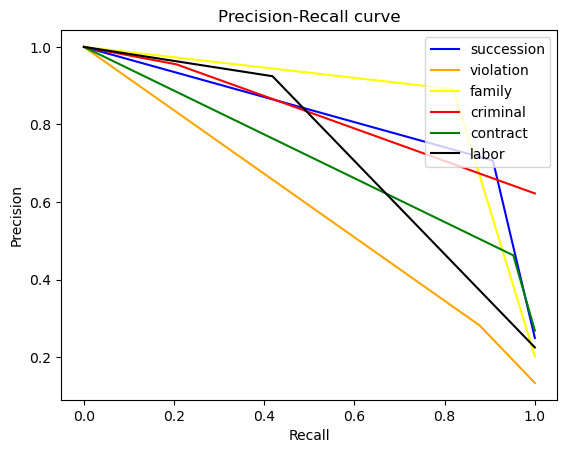

In [15]:
y_true = np.array(y_test)
y_pred = np.array(y_predict)
# Compute the precision and recall values for each class
precision = dict()
recall = dict()
n_classes = 6
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_true[:, i], y_pred[:, i])

# Plot the precision-recall curve for each class
import matplotlib.pyplot as plt
from itertools import cycle
colors = cycle(['blue', 'orange', 'yellow', 'red', 'green', 'black'])
label = ['succession', 'violation', 'family', 'criminal', 'contract', 'labor']
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color,
             label=label[i])
    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')
plt.title('Precision-Recall curve')
plt.show()


In [16]:
y_true[:, 1]

array([0, 0, 0, ..., 1, 0, 0])

In [18]:
precision = dict()
recall = dict()
average_precision = dict()
n_classes = 6
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_true[:, i], y_pred[:, i])
    average_precision[i] = metrics.average_precision_score(y_true[:, i], y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = metrics.precision_recall_curve(
   y_true.ravel(), y_pred.ravel()
)
average_precision["micro"] = metrics.average_precision_score(y_test, y_pred, average="micro")

In [19]:
len(recall)
average_precision = metrics.average_precision_score(y_true, y_pred)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.56


IndexError: invalid index to scalar variable.

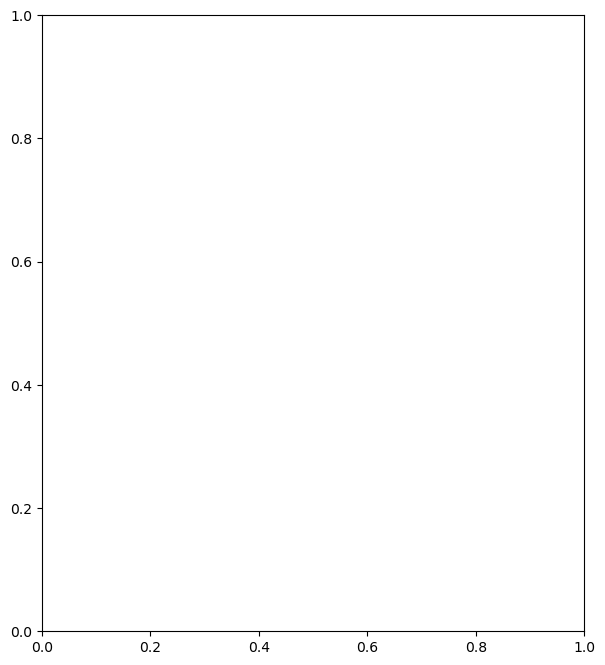

In [20]:
import matplotlib.pyplot as plt
from itertools import cycle

# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal" ,"black"])
_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
# for f_score in f_scores:
#     x = np.linspace(0.01, 1)
#     y = f_score * x / (2 * x - f_score)
#     (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
#     plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

for i, color in zip(range(n_classes), colors):
    display = metrics.PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
# handles.extend([l])
# labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="lower left")
ax.set_title("Precision-Recall curve")

plt.show()

In [75]:
from sklearn.multiclass import OneVsRestClassifier
classifier = OneVsRestClassifier(svm.LinearSVC(random_state=random_state))
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_test)
y_predict =  classifier.predict(X_test)

{0: array([0.24932442, 0.70666667, 1.        ]),
 1: array([0.13326696, 0.28179637, 1.        ]),
 2: array([0.20139383, 0.89093702, 1.        ]),
 3: array([0.62210212, 0.95517609, 1.        ]),
 4: array([0.26824065, 0.46229086, 1.        ]),
 5: array([0.22486133, 0.92577031, 1.        ])}